In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import fpfs
import galsim
import numpy as np
import matplotlib.pylab as plt
from fpfs.simutil import LensTransform

In [7]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

In [4]:
%%capture

UsageError: %%capture is a cell magic, but the cell body is empty.


In [8]:
### "Default Setting" ###
flux = 40
scale = 0.2
nn = 64
sersic_gal = galsim.Sersic(n=1.5, half_light_radius=1.5, flux=flux, trunc=4)

In [9]:
G1 = 0.000 ### fixing Flexion for now, this is in order to test whether there are some intrinsic bias 
### in our simulation setup
G2 = 0.000
F1 = 0.000
F2 = 0.000 

In [10]:
### Simulate across scale ###
### Convergence Test ###

kappa = 0.00
gamma1 = 0.03
gamma1_measured = np.zeros(50)
gamma2 = 0.0
#scale_array = np.logspace(np.log10(0.01),np.log10(0.2),50)
scale_array = np.linspace(0.2,0.06,50)
for i in range(len(scale_array)):
    lens = LensTransform(gamma1=gamma1, gamma2=gamma2, kappa=kappa,F1=F1,F2=F2,G1=G1,G2=G2)
    stamp = fpfs.simutil.Stamp(nn=64, scale=scale_array[i])
    stamp.transform_grids(lens)
    gal_array3 = stamp.sample_galaxy(sersic_gal)
    psf_array = np.zeros(stamp.shape)
    psf_array[nn // 2, nn // 2] = 1
    coords = np.array([nn//2, nn//2])
    fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale_array[i], sigma_arcsec=0.52)
    mms =  fpTask.measure(gal_array3, coords)
    mms = fpTask.get_results(mms)
    ells=   fpfs.catalog.fpfs_m2e(mms,const=20)
    resp1=np.average(ells['fpfs_R1E'])
    shear1=np.average(ells['fpfs_e1'])/resp1
    gamma1_measured[i] = shear1
    del stamp
    del lens

I0000 00:00:1698137730.206562   34146 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [11]:
### used to find the closest index to some cutoff scale ###
def closest_index(arr,num):
    return np.abs(arr-num).argmin()

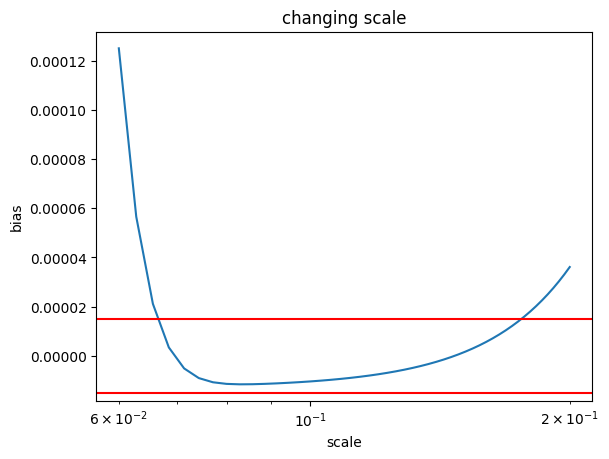

0.17714285714285716


In [12]:
"""It looks like the error decrease become real slow at at scale = 0.005"""
fig, ax = plt.subplots()
ax.plot(scale_array,gamma1_measured-gamma1)
ax.axhline(y=gamma1*0.05/100,c='r')
ax.axhline(y=-gamma1*0.05/100,c='r')
ax.set_xscale('log')
ax.set_xlabel('scale')
ax.set_ylabel('bias')
ax.set_title('changing scale')
plt.show()

index = closest_index(gamma1_measured-gamma1,gamma1*0.05/100) # difference below/closest to some error
print(scale_array[index])

In [26]:
### now we investigae if nn affects reconstruction error ###

kappa = 0.00
gamma1 = 0.03
scale = 0.2
gamma2 = 0.0
nn_array = np.array(list(range(64,2*64+1)))
gamma1_measured = np.zeros(len(nn_array))
for i in range(len(scale_array)):
    lens = LensTransform(gamma1=gamma1, gamma2=gamma2, kappa=kappa,F1=F1,F2=F2,G1=G1,G2=G2)
    stamp = fpfs.simutil.Stamp(nn=nn_array[i], scale=scale)
    stamp.transform_grids(lens)
    gal_array3 = stamp.sample_galaxy(sersic_gal)
    psf_array = np.zeros(stamp.shape)
    psf_array[nn_array[i] // 2, nn_array[i] // 2] = 1
    coords = np.array([nn_array[i]//2, nn_array[i]//2])
    fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.52)
    mms =  fpTask.measure(gal_array3, coords)
    mms = fpTask.get_results(mms)
    ells=   fpfs.catalog.fpfs_m2e(mms,const=20)
    resp1=np.average(ells['fpfs_R1E'])
    shear1=np.average(ells['fpfs_e1'])/resp1
    gamma1_measured[i] = shear1
    del stamp
    del lens

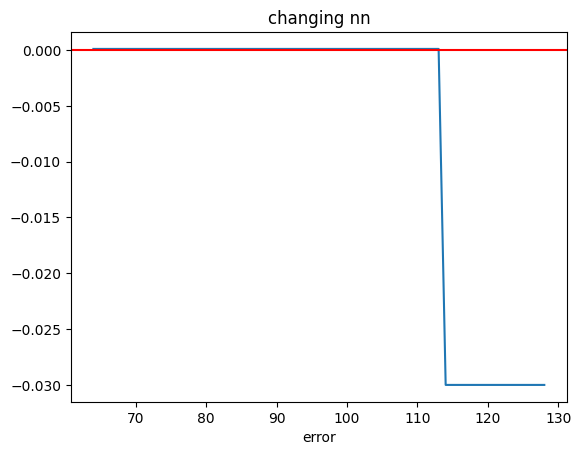

81


In [27]:
"""I don't really understand why nn is doing this"""
fig, ax = plt.subplots()
ax.plot(nn_array,gamma1_measured-gamma1)
ax.axhline(y=gamma1*0.05/100,c='r')
# ax.set_xscale('log')

ax.set_xlabel('nn')
ax.set_xlabel('error')
ax.set_title('changing nn')
plt.show()

index = closest_index(gamma1_measured-gamma1,gamma1*0.05/100) # difference below/closest to some error
print(nn_array[index])

In [28]:
### Simulate with different nn and half light radius ###
### Convergence Test ###

kappa = 0.00
gamma1 = 0.03
gamma2 = 0.0
n_array_len = 2
n_array = np.linspace(1,3,n_array_len)
half_light_radius_array_len = 2
half_light_radius_array = np.linspace(1,2,half_light_radius_array_len)
#scale_array = np.logspace(np.log10(0.01),np.log10(0.2),50)
scale_array = np.linspace(0.2,0.05,50)
gamma1_measured = np.zeros((n_array_len,half_light_radius_array_len,50))
nn_array = (0.2*64/scale_array).astype(int) # fix the size
for j in range(len(n_array)):
    for k in range(len(half_light_radius_array)):
        for i in range(len(scale_array)):
            sersic_gal = galsim.Sersic(n=n_array[j], half_light_radius=half_light_radius_array[k], flux=flux, trunc=4)
            lens = LensTransform(gamma1=gamma1, gamma2=gamma2, kappa=kappa,F1=F1,F2=F2,G1=G1,G2=G2)
            stamp = fpfs.simutil.Stamp(nn=nn_array[i], scale=scale_array[i])
            stamp.transform_grids(lens)
            gal_array3 = stamp.sample_galaxy(sersic_gal)
            psf_array = np.zeros(stamp.shape)
            psf_array[nn_array[i] // 2, nn_array[i] // 2] = 1
            coords = np.array([nn_array[i]//2, nn_array[i]//2])
            fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale_array[i], sigma_arcsec=0.52)
            mms =  fpTask.measure(gal_array3, coords)
            mms = fpTask.get_results(mms)
            ells=   fpfs.catalog.fpfs_m2e(mms,const=20)
            resp1=np.average(ells['fpfs_R1E'])
            shear1=np.average(ells['fpfs_e1'])/resp1
            gamma1_measured[j,k,i] = shear1
            del stamp
            del lens

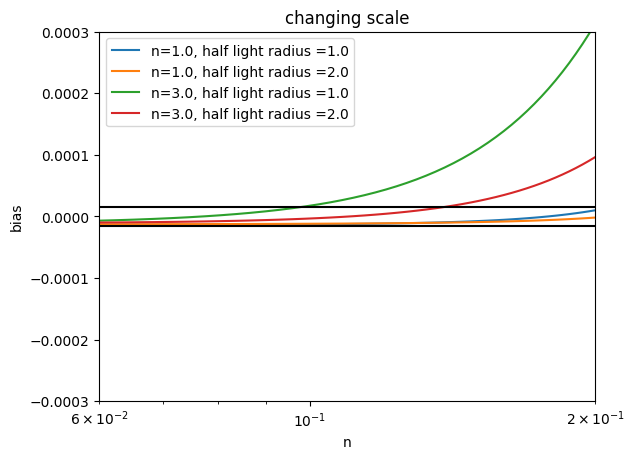

0.0989795918367347


In [32]:
fig, ax = plt.subplots()
for j in range(len(n_array)):
    for k in range(len(half_light_radius_array)):
        ax.plot(scale_array,gamma1_measured[j,k]-gamma1,label=f'n={n_array[j]}, half light radius ={half_light_radius_array[k]}')
ax.axhline(y=gamma1*0.05/100,c='k')
ax.axhline(y=-gamma1*0.05/100,c='k')
ax.set_xlim([6e-2,0.2])
ax.set_ylim([-0.0003,0.0003])
ax.set_xscale('log')
ax.set_xlabel('n')
ax.set_ylabel('bias')
ax.set_title('changing scale')
plt.legend()
plt.show()

index = closest_index(gamma1_measured[1,0]-gamma1,gamma1*0.05/100) # difference below/closest to some error
print(scale_array[index])